# Bike Sharing Analysis

Bike sharing is a fundamental service, commonly used in the urban mobility sector. <...snip...>. Therefore, understanding the driving factors of bike sharing requests is essential for both companies and users.

In [36]:
# supress warnings
import warnings
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# modules for statistical computing
from scipy.stats import ttest_1samp as samp
from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")

## Understanding The Data

In [2]:
# load hourly data
hourly_data = pd.read_csv("data/hour.csv")
hourly_data

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [3]:
hourly_data.shape

(17379, 17)

- Data contains 17379 rows and 17 columns

In [4]:
hourly_data.isnull().sum().sum()

0

- There are no missing values in the data

In [5]:
# .T is used to transpose the resulting data, hence columns become rows and vice versa.
hourly_data.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000


## Data Transformation

In this section, data will be transformed to more human-readable formats. This way hidden patterns and relationships might arise when data is wrangled correctly.

In [6]:
# crate data copy
preprocessed_data = hourly_data.copy()

# transform mappings
season_mapping = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'}
yr_mapping = {0: 2011, 1: 2012}
weekdays = {0: "sunday", 1: "monday", 2: "tuesday", 3: "wednesday", 
                4: "thursday", 5: "friday", 6: "saturday"}
weather_mapping = {1: "clear", 2: "cloudy", 3: "light_rain_snow",
                4: "heavy_rain_snow"}

# transform seasons
preprocessed_data['season'] = preprocessed_data['season'] \
                    .apply(lambda x:season_mapping[x])
# transform yr
preprocessed_data['yr'] = preprocessed_data['yr'] \
                    .apply(lambda x: yr_mapping[x])
# transform weekday
preprocessed_data['weekday'] = preprocessed_data['weekday'] \
                    .apply(lambda x: weekdays[x])
# tranform weathersit
preprocessed_data['weathersit'] = preprocessed_data['weathersit'] \
                    .apply(lambda x: weather_mapping[x])
# transform hum
preprocessed_data['hum'] = preprocessed_data['hum'] * 100
# transform windspeed
preprocessed_data['windspeed'] = preprocessed_data['windspeed'] \
                    * 67

columns = ['season', 'yr', 'weekday', 'weathersit', 'hum', \
                                            'windspeed']

preprocessed_data[columns].sample(10, random_state=42)

,season,yr,weekday,weathersit,hum,windspeed
12830,summer,2012,saturday,clear,27.0,12.9980
8688,winter,2012,monday,clear,41.0,15.0013
7091,fall,2011,friday,clear,66.0,19.0012
12230,spring,2012,tuesday,clear,52.0,23.9994
431,winter,2011,thursday,clear,56.0,26.0027
1086,winter,2011,friday,clear,72.0,19.0012
11605,spring,2012,thursday,clear,58.0,8.9981
7983,fall,2011,sunday,clear,87.0,0.0000
10391,winter,2012,wednesday,clear,68.0,12.9980
7046,fall,2011,wednesday,clear,71.0,15.0013


## Preprocessing Temporal and Weather Features

In [7]:
"""
assert that total numver of rides is equal to the sum of
registered and caual ones
"""
assert (
    preprocessed_data['casual'] \
        + preprocessed_data['registered'] \
    == preprocessed_data['cnt']).all(), \
    "Sum of casual and registered rides not equal " \
    "to total number of rides"

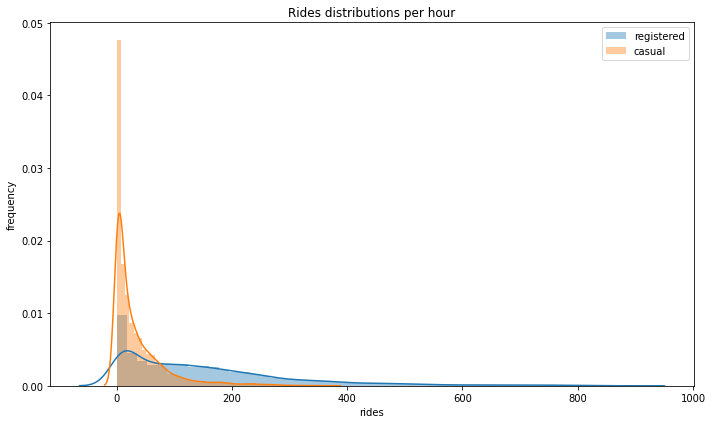

In [8]:
# plot distributions of registered vs casual rides
fig = plt.figure(figsize=(10,6))

sns.distplot(preprocessed_data['registered'], label="registered")
sns.distplot(preprocessed_data['casual'], label="casual")

plt.legend()
plt.xlabel('rides')
plt.ylabel('frequency')
plt.title("Rides distributions per hour")
plt.tight_layout()

plt.savefig("figs/rides_distribution.png", format="jpeg")
plt.show()

- Registered users perform way more rides than casual ones
- Both distributions are skewed to the right, meaning, for most of the entries in the data, zero or a small number of rides were registered.
- Every entry has quite a large number of rides (that is, higher than 800)

### Evolution of rides over time

#### Number of rides each day

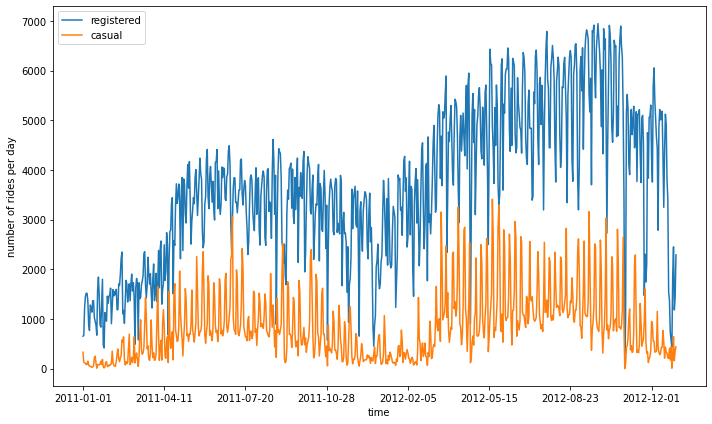

In [9]:
# plot evolution of rides over time
plot_data  = preprocessed_data[['registered', 'casual', 'dteday']]
ax = plot_data.groupby('dteday').sum().plot(figsize=(10,6))

ax.set_xlabel("time")
ax.set_ylabel("number of rides per day")
plt.tight_layout()

plt.savefig("figs/rides_daily.png", format='jpeg')
plt.show()

- The number of registered rides is always significantly higher than the number of casual rides per day.
- During the winter, the overall number of rides decreases (which is totally in line with my expectation, as bad weather and low tempreatures have a negative impact on ride-sharing services).

#### Number of rides each day (smoothed)

With the lot of variance in the time series above, it's necessary to smooth out the curves by taking the rolling mean and standard deviation of the two time series and plot those instead.

This way, visualisation is not only possible for the average number of rides for a specific time period (also known as a **window**) but also the expected deviation from the mean.

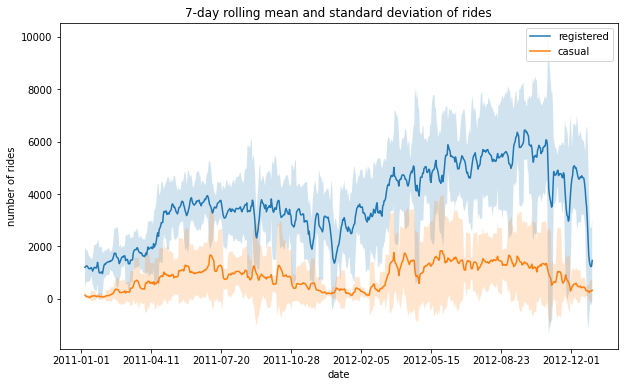

In [10]:
"""
Creating new dataframe with necessary for plotting columns, and obtain
number of rides per day, by grouping each day
"""

plot_data = preprocessed_data[['registered', 'casual', 'dteday']] \
                        .groupby('dteday').sum()

# window for computing mean and standard deviation
window = 7
rolling_means = plot_data.rolling(window).mean().round(decimals=2)
rolling_deviations = plot_data.rolling(window).std().round(
                                                     decimals=2)

# Create plot of the series, where we first plot the serie of rolling
# means, color the zone between the series of the rolling means +-2 
# rolling standard deviations.

ax = rolling_means.plot(figsize=(10,6))
ax.fill_between(rolling_means.index, 
                rolling_means['registered']
                + 2*rolling_deviations['registered'],
                rolling_means['registered'] - 2* 
                rolling_deviations['registered'],
                alpha=0.2)

ax.fill_between(rolling_means.index,
                rolling_means['casual']
                + 2*rolling_deviations['casual'],
                rolling_means['casual']
                - 2*rolling_deviations['casual'],
                alpha=0.2)

ax.set_title("7-day rolling mean and standard deviation of rides")
ax.set_xlabel("date")
ax.set_ylabel("number of rides")

plt.savefig("figs/rides_aggregated.png", format="jpeg")
plt.show()

### Daily and Hourly Basis

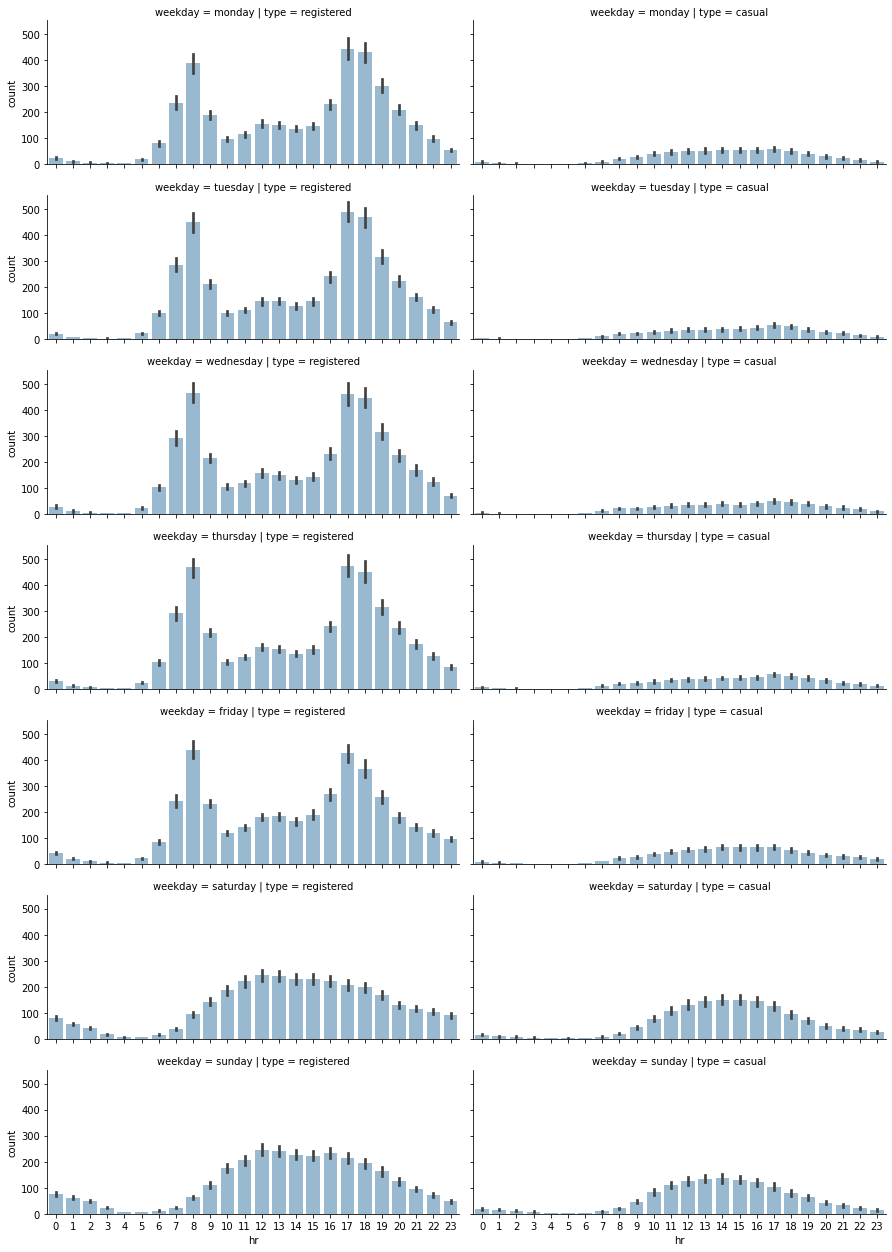

In [11]:
# select relevant columns
plot_data = preprocessed_data[['hr', 'weekday', 'registered', 'casual']]

# transform into count format
plot_data = plot_data.melt(id_vars=['hr', 'weekday',], 
                            var_name='type', value_name='count')

grid = sns.FacetGrid(plot_data, row='weekday',
                    col='type', height=2.5, aspect=2.5,
                    row_order = ['monday', 'tuesday', 'wednesday',
                        'thursday', 'friday', 'saturday', 'sunday'])

# populate the FacetGrid with the specific plots
grid.map(sns.barplot, 'hr', 'count', alpha=0.5)
grid.savefig('figs/weekday_hour_distributions.png', format='jpeg')

plt.show()

Working days:
- The highest number of rides for registered users takes place around 8 AM and 6PM. This is totally expected, as it is likely that most registered users use the bike sharing service for commuting.
- The casual usage of bike sharing service4s on working days is quite limited, as the plot shows.

Weekends:
- The distribution changes for both casual and registered users.
- The registered rides still outnumber the casual ones.
- Both distributions are almost uniformly distributed betwen the time interval of 11 AM to 6 PM.

We can claim that most of the usage of bike sharing services occurs during working days, right before and right after the standard working time (that is, 9 to 5).

### Analyzing Seasonal Impact on Rides

In this section, the impact of the different seasons on the total number of rides will be investigated. 

The goal is to create grid plots, similar to the previous in which the number of rides will be distributed overs hours and weekdays, based on the current season.

#### Hourly Distribution of Rides

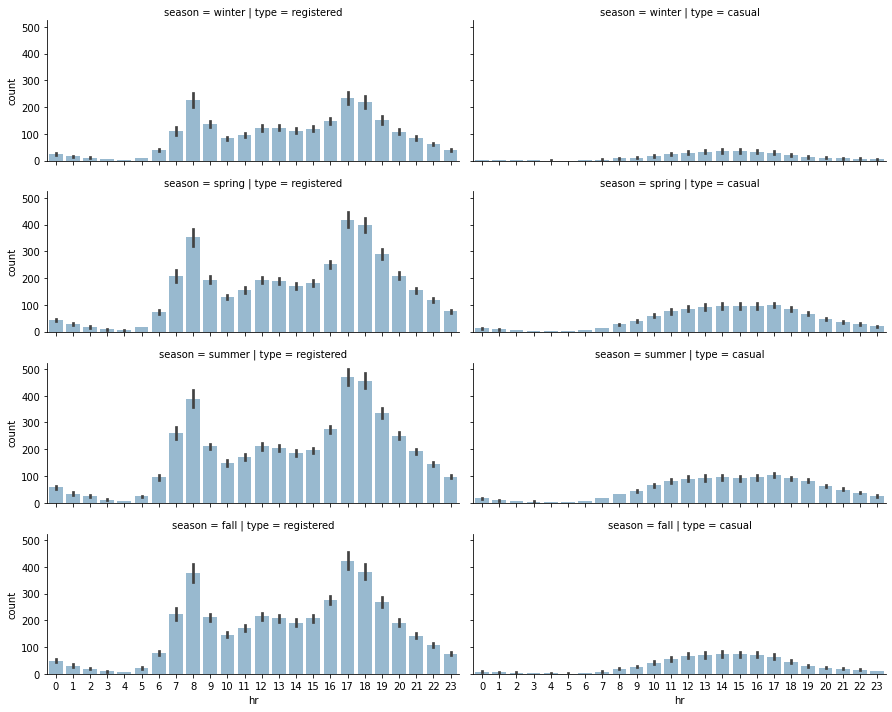

In [12]:
# select subset of data
plot_data = preprocessed_data[['hr', 'season', 
                            'registered', 'casual']]

# unpivot from wide to long format
plot_data = plot_data.melt(id_vars=['hr', 'season'],
                            var_name='type', value_name='count')

# define FacetGrid
grid = sns.FacetGrid(plot_data, row='season', 
                    col='type', height=2.5, aspect=2.5,
                    row_order=['winter', 'spring', 
                        'summer', 'fall'])


# apply plotting function to each element in the grid
grid.map(sns.barplot, 'hr', 'count',  alpha=.5)

grid.savefig('figs/season_hour_distributions.png', format='jpeg')
plt.show()


- Each season has a similar graph shape.
- There are fewer rides (registered and casual) during the winter. This makes sense, as fewer rides are likely to occur when the weather conditions are poor.

#### Daily Distribution of Rides

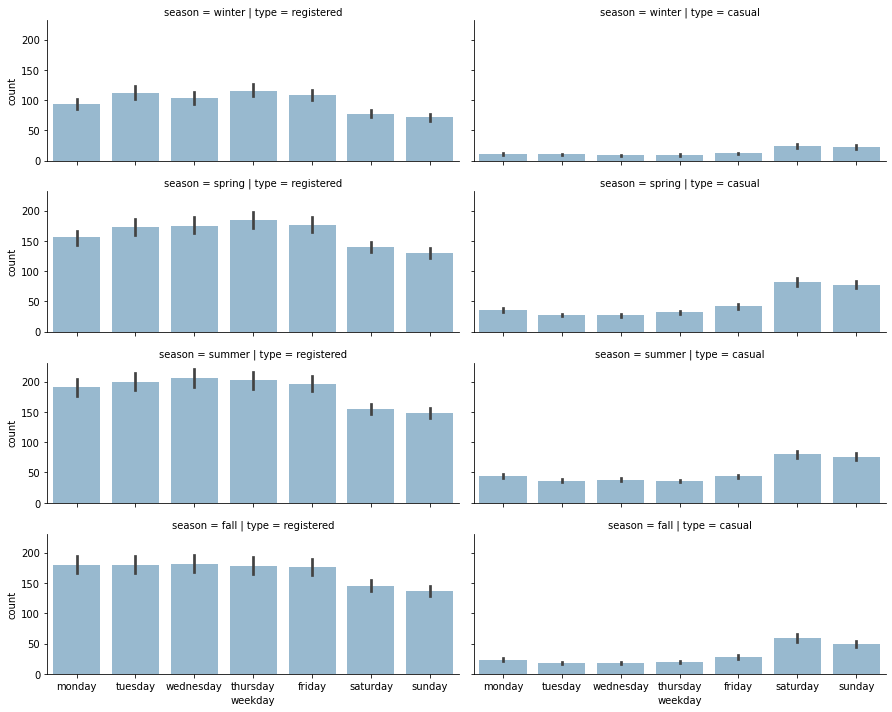

In [13]:
# select subsects
plot_data = preprocessed_data[['weekday','season', 
                                'registered', 'casual']]
# unpivot from wide to long format
plot_data = plot_data.melt(id_vars=['weekday', 'season'],
                            var_name='type', value_name='count')

grid = sns.FacetGrid(plot_data, row='season', col='type',
                        height=2.5, aspect=2.5, row_order=['winter',
                            'spring', 'summer', 'fall'])

grid.map(sns.barplot, 'weekday', 'count', alpha=0.5, 
            order= ['monday', 'tuesday', 'wednesday', 'thursday',
                'friday', 'saturday', 'sunday'])

plt.tight_layout()
plt.savefig('figs/season_weekday_distributions.png', format='jpeg')
plt.show()

- There is a decreasing number of registered rides over the weekend (compared to the rest of the week), while the number of casual rides increases.

This could enforce an initial hypothesis, that is, that registered customers mostly use the bike sharing service for commuting (which could be the reason for the decreasing number of registered rides over the weeekend)

## Hypothesis Tests

#### ESTIMATING AVERAGE REGISTERED RIDES 
Still on the topic of analyzing seasonal impact,
- Compute the average number of registered rides per hour. This is the value for formulating the null hypothesis.
- Collect the sample.
- Specify the significance level. A standard value is 0.05 (that is, when performing the statistical test), if the p-value ovteined by the statistical test is less than 0.05, you can reject the null hypoothesess by at least 95%.

In [14]:
# compute population mean of registered users
population_mean = preprocessed_data['registered'].mean()

# get sample of data (summer 2011)
sample = preprocessed_data[(preprocessed_data.season == 
            "summer") & (preprocessed_data.yr == 2011)].registered

# perform t-test and compute p-value
tests = samp(sample, population_mean)

print(f"Test statistic: {tests[0]:.4}, p-value: {tests[1]:.4}")

Test statistic: -3.492, p-value: 0.0004888


The result of the tests returns a p-value smaller than 0.001, which is less than the predefined critical value. Therefore, we can reject the null hyptothesis and assume that the alternative hyptothesis is correct.

In [15]:
# use sample as 5% of the full data
random.seed(111)
sample_unbiased = preprocessed_data \
                    .registered.sample(frac=0.05)

# calculate test statistic
tests_unbiased = samp(sample_unbiased, population_mean)

print(f"Unbiased test statistic {tests_unbiased[0]:.4}, "\
         f"p-value: {tests_unbiased[1]:.4}")

Unbiased test statistic -0.6497, p-value: 0.516


This indicates that tests results can be easily compromised when working with biased data. It is important to have an unbiased sample.

#### HYPTOTHESIS TESTING ON REGISTERED RIDES
1. Formulate the null hyptotheis. 
  
    > Is there a significant difference between registered rides during working days and the weekend?

    Therefore, the null hypothesis is that the average number of rides for registered uses during the working days is same as the average number of rides during the weekdend. In other words:

    $ H_0 $: average registered rides over the weekday - average registered rides over weekends = 0.

    $ H_a $: average registered rides over the weekday - average registered rides over weekends $\neq$ 0.

2. After null and alternative hypothesis is established, collect data for the two groups. 

3. Perform the two-sample t-tests by using the **scipy.stats.ttest_ind**.

4. Plot the distribution of two samples.

5. Perform the same type of hypothesis testing to validate the second assumption from the last section -- that is, casual users perform more rides during the weekend. 
    
    > Is the average number of rides during the working days the sasame as the average number of rides during the weekend, for casual users?

    Therefore, the alternative hypothesis will then result in a statistically significant difference in the average number of rides between the two groups.

In [16]:
# define mask, indicating if the day is a weekend or work day
weekends = ['saturday', 'sunday']

weekends_mask = preprocessed_data.weekday.isin(weekends)
workdays_mask = ~preprocessed_data.weekday.isin(weekends)

# select registered rides for the weekend and working days
weekends_data = preprocessed_data.registered[weekends_mask]
workdays_data = preprocessed_data.registered[workdays_mask]

In [17]:
# perform ttest
test_res = ttest_ind(weekends_data, workdays_data)

print(f"Statistic value: {test_res[0]:.03f}", \
    f"p-value: {test_res[1]:.03f}")

Statistic value: -16.004 p-value: 0.000


The resulting p-value from this test is less than 0.0001, which is far below the standard critical 0.05 value. As conclusion, we can reject the null hypothesis and confirm that our initial observation is correct: that is, there is statistically a significant difference between the number of rides performed during the working days and the weekends.

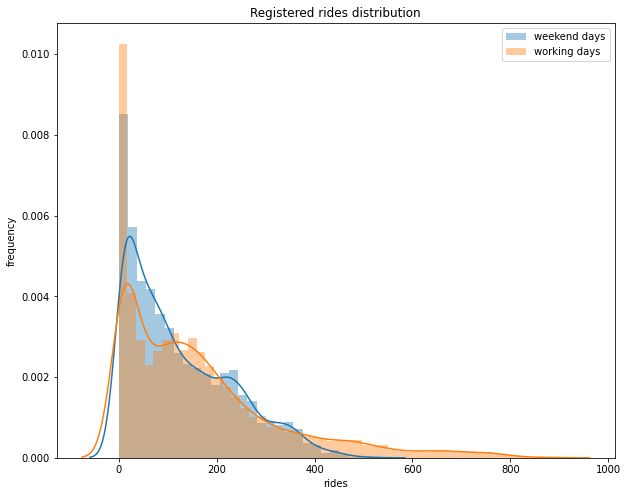

In [18]:
# distribution plot of registered rides for working vs weekend days.
fig = plt.figure(figsize=(10,8))
sns.distplot(weekends_data, label='weekend days')
sns.distplot(workdays_data, label='working days')

plt.xlabel('rides')
plt.ylabel('frequency')
plt.title('Registered rides distribution')

plt.legend()
plt.savefig('figs/registered_rides_distribution.png', format='jpeg')
plt.show()

Statistic value: 41.077,p-value: 0.000


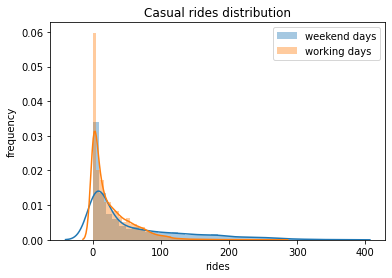

In [19]:
# select casual rides for the weekend and working days
weekend_data = preprocessed_data.casual[weekends_mask]
workdays_data = preprocessed_data.casual[workdays_mask]

# perform t-test
test_res = ttest_ind(weekend_data, workdays_data)
print(f"Statistic value: {test_res[0]:.03f},"\
        f"p-value: {test_res[1]:.03f}")

# plot distribution of casual rides for working vs weekend days
sns.distplot(weekend_data, label='weekend days')
sns.distplot(workdays_data, label='working days')

plt.legend()
plt.xlabel("rides")
plt.ylabel("frequency")

plt.title("Casual rides distribution")
plt.savefig("figs/casual_rides_distribution.png", format="jpeg")
plt.show()

The p-value returned is 0, which is strong evidence against the null hypothesis. Hence, casual customers also behave differently over the weekend (in this case, they tike sharing service more) as seen in the plot.

## Correlation Testing

In this section, I'll focus on analysis of the group of features representing the weather conditions. My expectation is to observe a strong dependency of those features on the current number of rides, as bad weather can significantly influence bike sharing services.

### ANALYSIS OF WEATHER-RELATED FEATURES
As most of the weather features seem to be continously distributed, the first and most common way to measure the relationship between two different continous variable is to measure their correlation.

In [20]:
def plot_correlation(data, col):
# get correlation between col and registered rides
    corr_r = np.corrcoef(data[col], data["registered"])[0,1]
    ax = sns.regplot(x=col, y = "registered", data=data,
        scatter_kws = {"alpha": 0.05}, 
        label=f"Registered rides (correlation: {corr_r:.3f})")
    
    corr_c = np.corrcoef(data[col], data["casual"])[0,1]
    ax = sns.regplot(x=col, y = "casual", data = data, 
        scatter_kws = {"alpha": 0.05}, 
        label = f"Casual rides (correlation: {corr_c:.3f}")

    # adjust legend alpha
    legend = ax.legend()

    for lh in legend.legendHandles:
        lh.set_alpha(0.5)

    ax.set_ylabel("rides")
    ax.set_title(f"Correlation between rides and {col}")
    return ax

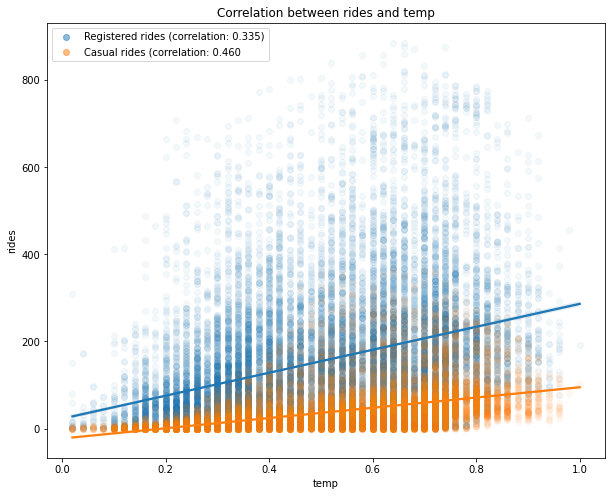

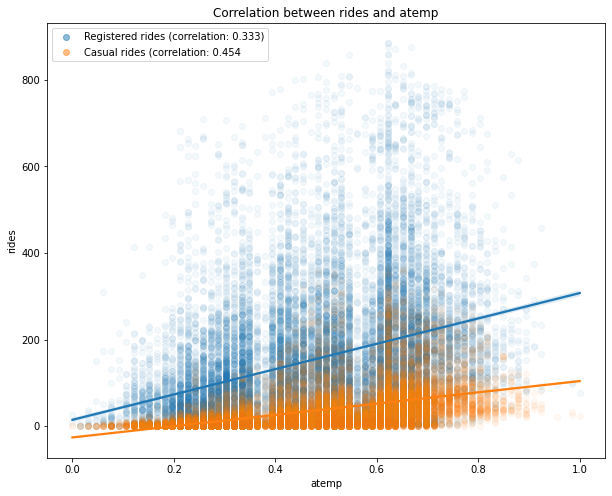

In [21]:
fig = plt.figure(figsize=(10,8))
ax = plot_correlation(preprocessed_data, "temp")
plt.savefig("figs/correlation_temp.png", format="jpeg")

fig = plt.figure(figsize=(10,8))
ax = plot_correlation(preprocessed_data, "atemp")
plt.savefig("figs/correlation_atemp.png", format="jpeg")

Plotting **hum** and **windspeed** seperately:

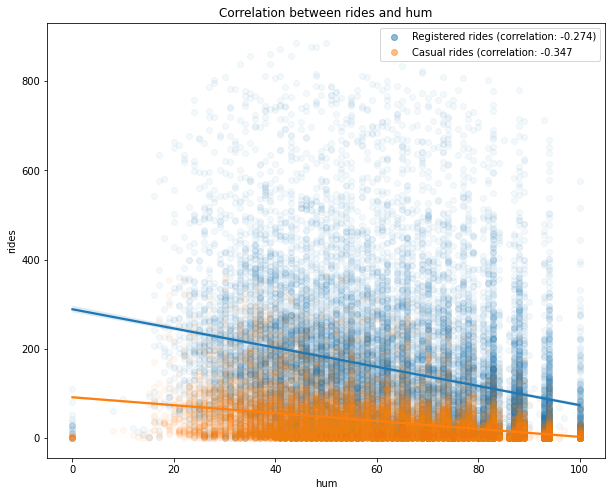

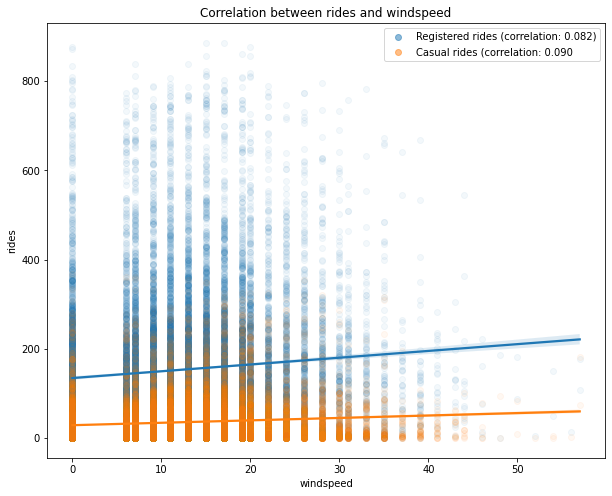

In [22]:
fig = plt.figure(figsize=(10,8))
ax = plot_correlation(preprocessed_data, "hum")
plt.savefig("figs/correlation_hum.png", format="jpeg")

fig = plt.figure(figsize=(10,8))
ax = plot_correlation(preprocessed_data, "windspeed")
plt.savefig("figs/correlation_windspeed.png", format="jpeg")

It is observable that higher tempreatures have a positive impact on the number of rides. Note  that as the values in the **registered** colum are widely spread with respect to the different values in **temp**, there is a lower correlation compared to the **casual** column. The same pattern is observed in the **hum** visuals where the humidity level has a negative correlation with both types of rides.

This means that with a high level of humidity (mist or rain), customers will tend not to use the bike sharing service. Lastly, there is a minimal correlation between the number of rides and the weind speed (weak positive correlation).

#### Evaluating Pearson Vs. Spearman Correlation

This section investigates the difference between the Pearson correlation (in which a linear relationship between the two variables is assumed) and the Spearman correlation (in which only a monotonic relationship is required). This will help me to understand the difference between the two types of correlations, especially when the data does not satisfy the linear assumption. To better present the difference between the two measures, synthetic data will be used to serve this purpose:

1. Defining random variables: **X** will represent an independent variable, and two dependent ones, **Y<sub>lin</sub>** and **Y<sub>mon</sub>** which can be expressed as:

$ Y_{lin} = 0.5 \cdot + \sigma $
<br>
<span>Expression for the dependent variable $Y_{lin}$ </span>

$ Y_t = T_t + S_t + R_t $
<br>
<span>Expression for the dependent variable $Y_{mon}$ </span>

Hence, $\sigma$ represents a noise component, which is normally distributed with a mean of 0 and a standard deviation of 0.1: 

2. Compute the Pearson and Spearman corerlaions using method from **scipy.stats** module.

The **pearsonr()** and **spearmanr()** methods return a two-dimensional array in which the first value is the respective correlation, while the second one is the p-value of a hypothesis test in ehich the null hypothesis assumes that the computed correlation is equal to zero. This can help test its statistical significance against being zero.

3. Visualize both the data and the computed correlations.

In [23]:
# define random variables
x = np.linspace(0,5,100)
y_lin = 0.5 * x + 0.1 * np.random.randn(100)
y_mon = np.exp(x) + 0.1 * np.random.randn(100)

corr_lin_pearson = pearsonr(x, y_lin)[0]
corr_lin_spearman = spearmanr(x, y_lin)[0]

corr_mon_pearson = pearsonr(x, y_mon)[0]
corr_mon_spearman = spearmanr(x, y_mon)[0]

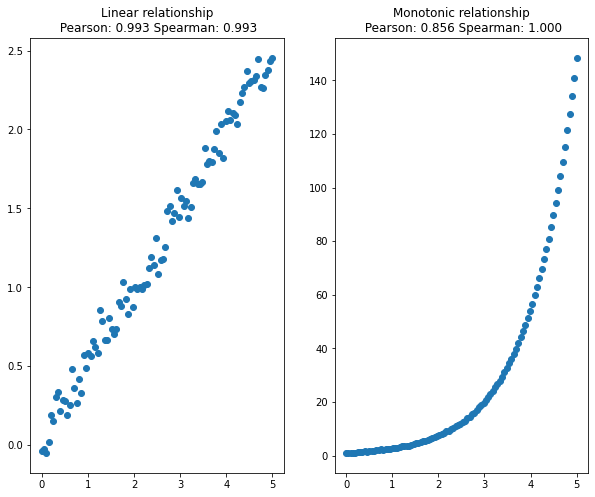

In [24]:
# visualize variables
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,8))

ax1.scatter(x,y_lin)
ax1.set_title(f"Linear relationship\n \
Pearson: {corr_lin_pearson:.3f} \
Spearman: {corr_lin_spearman:.3f}")

ax2.scatter(x, y_mon)
ax2.set_title(f"Monotonic relationship\n \
Pearson: {corr_mon_pearson:.3f} \
Spearman: {corr_mon_spearman:.3f}")

fig.savefig("figs/pearson_vs_spearman.png", format="jpeg")

When the relationship between the two variables is linear (the figure on the left), the two correlation coefficients are very similar. In the monotonic relationship, the linear assumption ofs the Pearson correlation fails, and although the correlation coefficient is still quite hig (0.856), it is not capable of capturing the perfect relationship between the two variables. On the other hand, the Spearman correlation coefficient is 1, which means that is succeds in captureing the almost perfect relataionship between the two variables.

4. Returning to the bike sharing data, the relationship between the different variables in light of the difference between the two correlation measures will be investigated. In summary, the Pearson and Spearman correlation coefficients with the **registered** and **casual** rides will be computed.

In [25]:
# defining function for computing correlations
def compute_correlations(data: pd.DataFrame, 
                col: pd.Series) -> pd.Series:

    pearson_reg = pearsonr(data[col], data["registered"])[0]
    pearson_cas = pearsonr(data[col], data["casual"])[0]
    spearman_reg = spearmanr(data[col], data["registered"])[0]
    spearman_cas = spearmanr(data[col], data["casual"])[0]

    return pd.Series({"Pearson (registered)": pearson_reg, 
                      "Spearman (registered)": spearman_reg,
                      "Pearson (casual)": pearson_cas,
                      "Spearman (casual)": spearman_cas})

In [26]:
# compute correlation measures between different features
cols = ["temp", "atemp", "hum", "windspeed"]

corr_data = pd.DataFrame(index=["Pearson (registered)",
                                "Spearman (registered)",
                                "Pearson (casual)",
                                "Spearman (casual)"])
for col in cols:
    corr_data[col] = compute_correlations(preprocessed_data, 
                                            col)

corr_data.T

,Pearson (registered),Spearman (registered),Pearson (casual),Spearman (casual)
temp,0.335361,0.373196,0.459616,0.570989
atemp,0.332559,0.373014,0.454080,0.570419
hum,-0.273933,-0.338480,-0.347028,-0.388213
windspeed,0.082321,0.122936,0.090287,0.122920


For most of the variables, the Pearson and Spearman correlation coefficient are close enough (some linearity is to be expected). The most striking difference betweeen the two coefficients occurs when comparing the **temp** (and **temp**) and **casual** columns. More precisely, the Spearman correlation is quite high, meaning that there is significant evidence for a non-linear, relative strong and positive.

A simple interpretation of this result is that the casual customers are far keener on using the bike sharing service when the tempreatures are higher. From previous analysis, the casual customers ride mostly during the weekend, and they do not rely on bike sharing serveice for commuting purposes. This conclusion is again confirmed by the strong relationship with temperature, as opposed to registered customers, whose rides have a weaker correlation with temperature.

#### Correlation Matrix

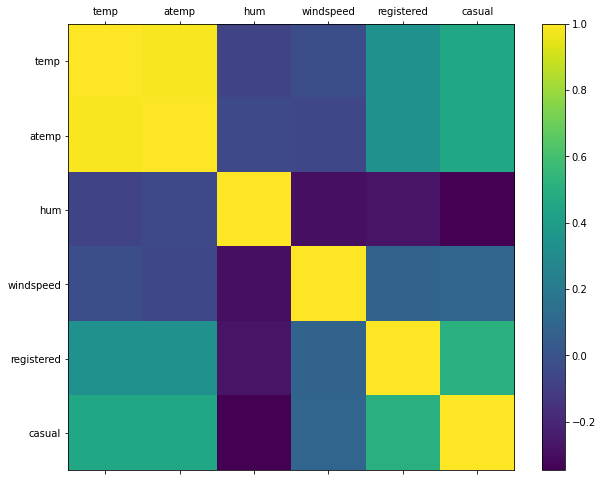

In [27]:
# plot correlation matrix
cols = ["temp", "atemp",  "hum", "windspeed",
        "registered", "casual"]

plot_data = preprocessed_data[cols]
corr = plot_data.corr()

fig = plt.figure(figsize=(10,8))
plt.matshow(corr, fignum=fig.number)

plt.xticks(range(len(plot_data.columns)), plot_data.columns)
plt.yticks(range(len(plot_data.columns)), plot_data.columns)
plt.colorbar()

plt.savefig("figs/correlation_matrix.png", format="jpeg")
plt.show()

This concludes my analysis of the weather columns and their respective impact on the number of rides.

## Time Series Analysis

### Stationarity

When studying time series, an important concept is the notion of stationarity. A time series is said to be *strongly stationary* if all aspects of its behavior do not change in time. It is possible to have a time a time series that is *weakly stationary*, that is, its mean, standaard deviation, and covariance are stationary with respect to time.

The **Augumented Dickey-Fuller stationarity test** can be used to identify stationarity in a time series. This is a statistical test in which the null hypothesis is that the time series is nonstationary. Hence when performing the test, a small p-value would be strong evidence against the time series being non-stationary.

In [28]:
def test_stationarity(ts, col, window=10, **kwargs):
    plot_data = pd.DataFrame(ts)
    plot_data["rolling_mean"] = ts[col].rolling(window).mean()
    plot_data["rolling_std"] = ts[col].rolling(window).std()
    # compute p-value of Dickey-Fuller test
    p_val = adfuller(ts[col])[1]
    ax = plot_data.plot(**kwargs)
    ax.set_title(f"Dicker-Fuller p-value: {p_val:.3f}")
    ax.get_figure().savefig(f"figs/stationarity_test_{col}.png", 
                                format="jpeg")

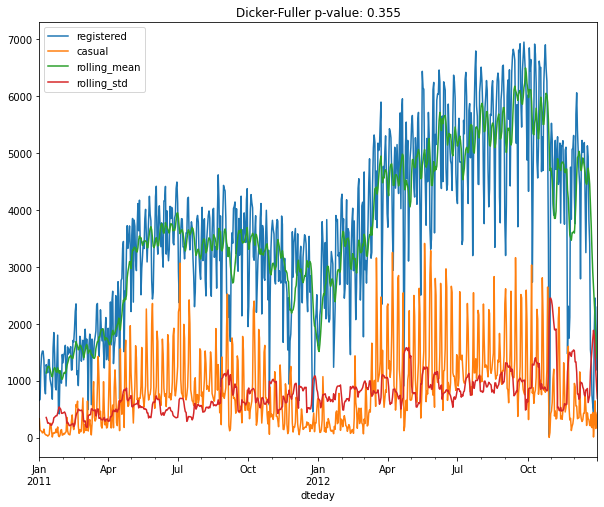

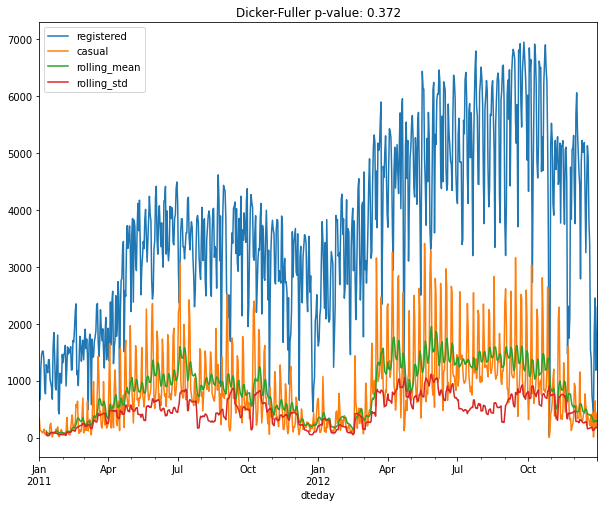

In [29]:
# get daily rides
daily_rides = preprocessed_data[["dteday", "registered",
                                    "casual"]]
daily_rides = daily_rides.groupby("dteday").sum()

# convert index to DateTime object
daily_rides.index = pd.to_datetime(daily_rides.index)

# apply to stationary test
test_stationarity(daily_rides, "registered", figsize=(10,8))
test_stationarity(daily_rides, "casual", figsize=(10,8))

From the performed tests, it is obvious that neither the moving average nor standard deviations are stationary. Furthermore, the Dickey-Fuller test returns values of 0.355 and 0.372 for **registered** and **casual** users, respectively. This is strong evidence that the time series is not stationary, and we need to process them in order to obtain a stationary one.

### Detrending a Time Series

A common way to detrend a time series and make it stationary is to subtract either its rolling mean or its last value, or to decompose it into a component that will contain its trend, seasonality, and resudial components. Below, we check if the time series by subtracting theri rolling means and last values.

In [30]:
def test_stationarity_2(ts, window=10, **kwargs):
    plot_data = pd.DataFrame(ts)
    plot_data["rolling_mean"] = ts.rolling(window).mean()
    plot_data["rolling_std"] = ts.rolling(window).std()
    # compute p-value of Dickey-Fuller test
    p_val = adfuller(ts)[1]
    ax = plot_data.plot(**kwargs)
    ax.set_title(f"Dicker-Fuller p-value: {p_val:.3f}")
    ax.get_figure().savefig(f"figs/stationarity_test_{col}.png", 
                                format="jpeg")

<Figure size 432x288 with 0 Axes>

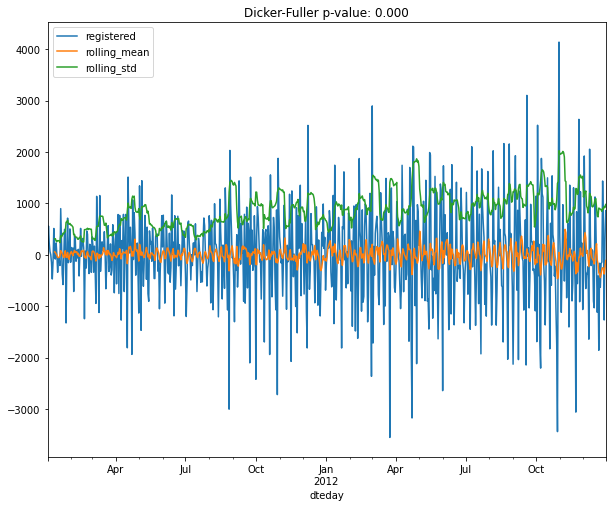

<Figure size 432x288 with 0 Axes>

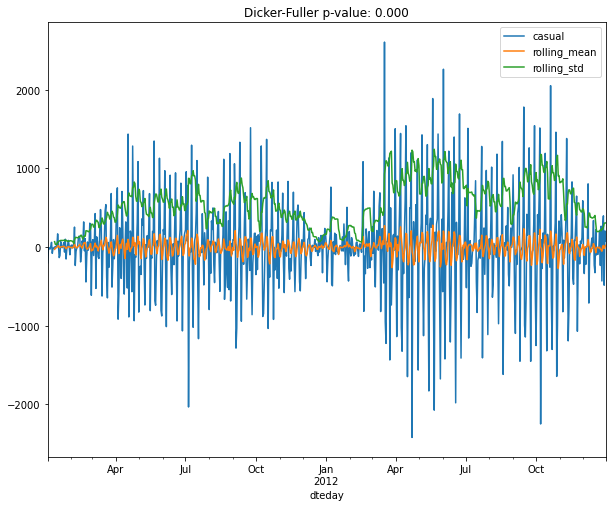

In [31]:
# subtracting the last value
registered = daily_rides["registered"]
registered_diff = registered - registered.shift()
registered_diff = registered_diff.dropna()

casual = daily_rides["casual"]
casual_diff = casual - casual.shift()
casual_diff = casual_diff.dropna()


plt.figure()
test_stationarity_2(registered_diff, figsize=(10,8))
plt.savefig("figs/daily_registered_diff.png", format="jpeg")

plt.figure()
test_stationarity_2(casual_diff, figsize=(10,8))
plt.savefig("figs/daily_casual_diff.png", format="jpeg")

Both techniques (rolling mean and last value shifting) returned a time sereies, which is stationary, according to the Dickey-Fuller test (0.00). Note that an interesting pattern occurs in the casual series: a rolling standard deviation exhibits a clustering effect, that is, periods in which the standard deviation is higher and periods which it is lower.

This effect is also commmon in certain fields (finance, for instance) and is also known as **volatility clustering**.

A possible interpretation, relative to the data, is that the number of casual rides increses during the summer periods and drops during the winter.

#### Time Series Decomposition

Another technique for detrending time series is a previously mentioned technique, **time series decomposition**. This involves breaking the time series into seperate components.

- *Trend component*: This component represents a long-term progression of the series. A trend component is present when there is a persistent increase or decrease in the series.

- *Seasonal component*: This component represents seasonality patterns in the data. A seasonal component persists when the data is influenced by certain seasonal factors  (for exxample, monthly, quarterly or yearly factors).

- *Residual component*: This componnet represents an irregular or noisy component. This component describes random fluctuation in the data, which are not captured by the other components. In general, this is the residual of the time series, that is, once the other components have bee removed.

The decomposition is *additive* if the following holds:

$ Y_t = T_t + S_t + R_t $

The decomposition is *multiplicative* if,

$ Y_t = T_t \cdot S_t \cdot R_t $

In [32]:
# decomposing registered and casual rides
registered_decomposition = seasonal_decompose(\
                            daily_rides["registered"])
casual_decomposition = seasonal_decompose(daily_rides\
                                        ["casual"])

To access each of these three signals, use **.trend**, **.seasonal** and **.resid**. Furthermore, obtain visual results from the generated decompositions by calling the **.plot()** method.

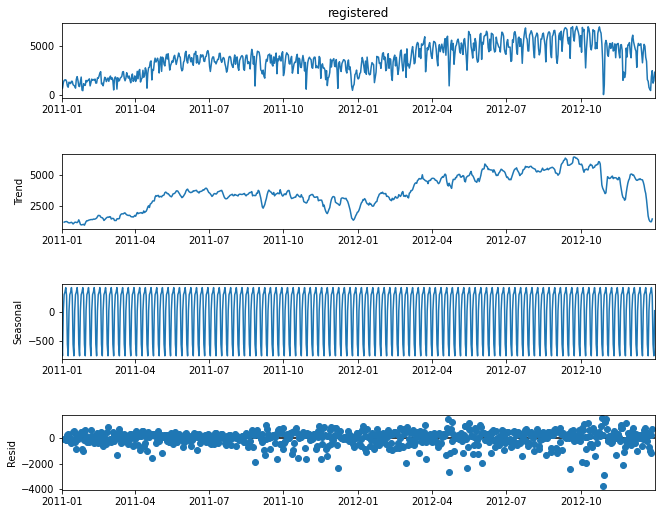

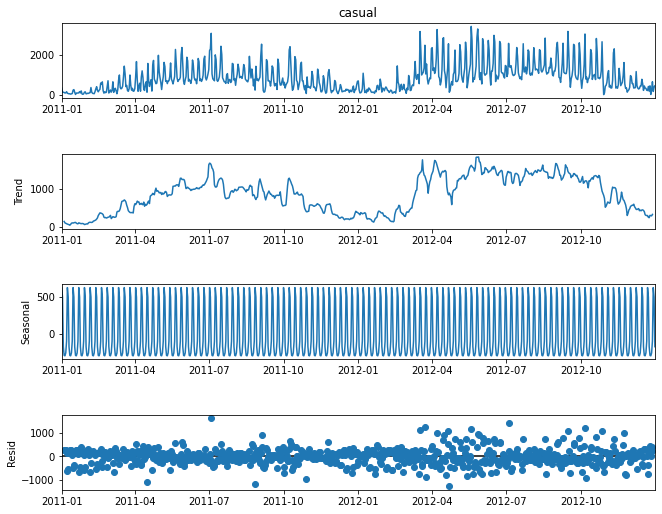

In [33]:
# plot decompositions
registered_plot = registered_decomposition.plot()
registered_plot.set_size_inches(10,8)
registered_plot.savefig("figs/registered_decomposition.png",
                        format="jpeg")

casual_plot = casual_decomposition.plot()
casual_plot.set_size_inches(10,8)
casual_plot.savefig("figs/casual_decomposition.png",
                    format="jpeg")

Test the residuals obtained for stationarity:

<Figure size 432x288 with 0 Axes>

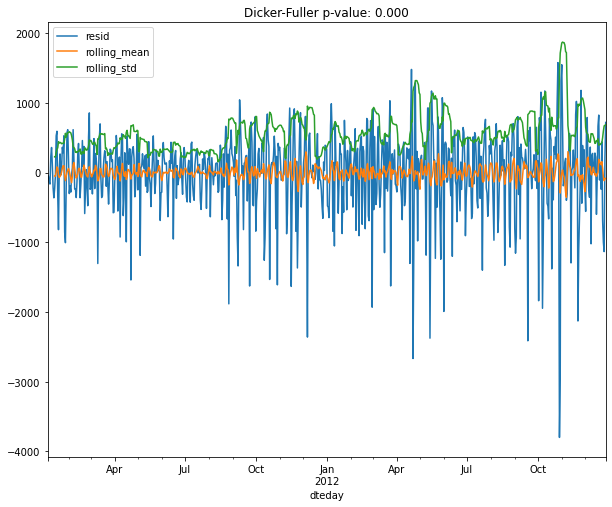

<Figure size 432x288 with 0 Axes>

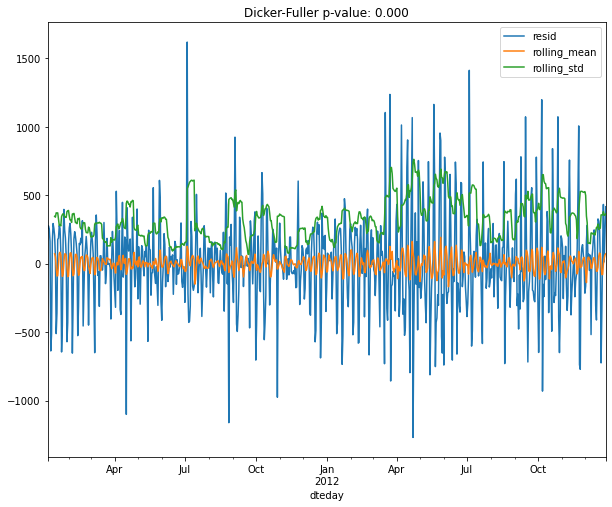

In [34]:
# test residuals for stationarity
plt.figure()
test_stationarity_2(registered_decomposition.resid.dropna(),
                    figsize=(10,8))
plt.savefig("figs/registered_resid.png", format="jpeg")

plt.figure()
test_stationarity_2(casual_decomposition.resid.dropna(),
                    figsize=(10,8))
plt.savefig("figs/casual_resid.png", format="jpeg")

As you can see, the residual satisfy our stationarity test.

### Modelling Time Series

A common approach to modelling a time series is to assume that past ovservations somehow influence future ones. For instnace, customers who are satisfied by using the bike sharing service will more likely recommend it, producing, in this way, a positive impact on the service and a higher number of customers (any negative feedback has the opposite effect, reducing the number of customers). 

Hence, increasing the number of customers and the quality of the service increases the number of recommendations and, therefore, then number of new customers. In this way, a positive feedback loop is created, in which the current number of rides correlates with its past values.

#### ARIMA MODELS
**Autoregressive Integrated Moving Average (ARIMA)** models are a class of statistical models that try to explain the behaviour of a time series using its own past values. 

Being a class of models, ARIMA models are defined by a set of parameters **(p,d,q)** each one corresponsding to a different component of the ARIMA model:

- **Autoregressive of order p**: An autoregressive model of order **p (AR(p)** for short) models the current time series entry as a linear combinarion of its las p values. The mathematical formulation is:

$ Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \cdot \cdot \cdot + \beta_p Y_{t-p} + \epsilon_t $

Here $\alpha$ is the intercept term, $Y_{t-i}$  is the lag-i term of the time series with the respective coefficient $\beta_i$ while $\epsilon_t$ is the error term (that is , the normally distributed random variable with mean 0 and variance $\sigma_\sigma^2$).

- **Moving average of order q**: A moving average model of order **q (MA(q)** for short) attempts ot model the current value of the time series as a linear combination of its past error terms. Mathematically speaking, it has the formula:

$Y_t = \alpha + \epsilon_t + \phi_1 + \epsilon_{t-1} + \cdot \cdot \cdot + \phi_q \epsilon_{t-q} $

As in the autoregressive model $\alpha$ represents a bias term; $\phi_{1,...,}\phi_q$ are parameters to be estimated in the model; and $\epsilon_{t,...,}\epsilon_{t-q}$ are the error terms at times **t,...t-q** respectively.

- **Integrated componsnet of order d**: The intergrated component represents a transformation in the original time series, in which the transformed series is obtained by getting the difference between $Y_t$ and $Y_{t-d}$, hence the following:

$Z_t = Y_t - Y{t-d}$

The integrating term is used for detrending the original time series and making it stationary. Previously, we have seen this type of transformation when the previous entry in the number of rides was subtracted, that is, and integration term of order 1 was applied.

In genearal when an ARIMA model of order (p,d,q) is applied to a time series, **{ $Y_t$ }**, the model obtained:

$ Z_t = Y_t - Z_{t-d}$

Then, apply a combinarion of AR(p) and MA(q) models, also known as the autoregressive moving average model, or ARMA(p,q) to the transformed series, **{ $ Z_t$ }**:

$ Z_t = \alpha + \beta_1 Z_{t-1} + \cdot \cdot \cdot + \beta_p Z_{t-p} + \phi_1 \epsilon + \cdot \cdot \cdot + \phi_q \epsilon_{t-q} + \epsilon_t $

The coefficients $ \alpha, \beta_1, ...., \beta_p, \phi_1,...,\phi_q $ are to be estimated

In practice, the ACF measures the complete correlation between the current entry, **{ $Y_t$ }** and its past entries, lagged by **k**. Note that when computing the ACF(k), the correlation between **$Y_t$** with all intermediate values (**$Y_{t-1},...,Y_{t-k}$)**, the PACF is often referred to, which only measures the impact of **$Y_{t-k}$** on $Y_t$

ACF and PACF are, in general, used to determin the order of integration when modelling a time series with an ARIMA model. For each lag, the correlation coefficient and level of significance are computed. In general, we aim at an integrated series, in which only the first few lags have correlation greater than the level of significance.